In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import math
import sys
import requests
from bs4 import BeautifulSoup
from pathlib import Path
from datetime import datetime
from io import StringIO
from pyspark.sql import SparkSession
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/gyalm/Desktop/ect_allocation_model/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# DSWD ECT Payout Criteria (Simulated based on common DSWD guidelines)
# The CatBoost model will learn to classify the payout based on these inputs.
PAYOUT_CRITERIA = {
   'Totally Damaged': 10000,  # Max Payout for totally damaged homes
   'Partially Damaged': 5000, # Mid Payout for partially damaged homes
   'Not Damaged': 0,          # No Payout
}

In [18]:
# --- ETL for Historical Flood Data (DOST-ASTI Sensors, Philippines) ---
import sys
import importlib
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
ETL_ROOT = PROJECT_ROOT / "etl"
for path in (PROJECT_ROOT, ETL_ROOT):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

import scrape_waterlevel
import scrape_households
importlib.reload(scrape_waterlevel)
importlib.reload(scrape_households)

from scrape_waterlevel import (
    DEFAULT_ENDPOINTS,
    get_default_cache_path,
    load_and_aggregate_flood_data,
 )
from scrape_households import DEFAULT_SOURCES, load_household_measurements, generate_base_training_data

OFFICIAL_ENDPOINTS = DEFAULT_ENDPOINTS
ETL_CACHE_PATH = get_default_cache_path()

HOUSEHOLD_SOURCES = DEFAULT_SOURCES
HOUSEHOLD_BBOX = (120.85, 14.45, 121.15, 14.85)

In [4]:
# Load and aggregate historical flood data by location

df_hist, df_hist_agg = load_and_aggregate_flood_data(
    cache_path=ETL_CACHE_PATH,
    endpoints=OFFICIAL_ENDPOINTS,
 )

print("df_hist.head(5):")
print(df_hist.head(5))
print("df_hist shape:", df_hist.shape)
print("df_hist_agg shape:", df_hist_agg.shape)

df_hist.head(5):
   station_id Region         Province                           Location  \
0        2969  BARMM      MAGUINDANAO            DELTA II SULTAN KUDARAT   
1        3263     11   Davao Oriental  25. MATI CITY DAVAO ORIENTAL SLMS   
2        2987  BARMM    LANAO DEL SUR                BRGY. TABORO BRIDGE   
3        2255      1       Pangasinan         1. BOLINAO PANGASINAN SLMS   
4        3051     13  Surigao Del Sur  15. HINATUAN SURIGAO DEL SUR SLMS   

   type_id alert alarm critical      0      1      2     3      4      5  \
0        4  None  None     None  11.72  11.41  11.47  11.7  12.04  12.49   
1        8  None  None     None   9.02   9.22   9.27  9.25   9.13   8.85   
2        3  None  None     None   7.55   7.53    7.5  7.47   7.44   7.44   
3        8  None  None     None   6.58   6.57   6.69  6.75   6.85   6.83   
4        8  None  None     None   6.07    6.2   6.21   6.2   6.08   5.86   

      6      7      8     9     10     11     12     13     14     15

In [5]:
# Check whether the historical flood data is synthetic or cached
source = df_hist.attrs.get("source")
print("df_hist attrs source:", source)
if source is None:
    print("No source attribute found; data may have been loaded from cache.")
    print("Cache path:", ETL_CACHE_PATH)
    try:
        print("Cache exists:", ETL_CACHE_PATH.exists())
    except Exception as exc:
        print("Cache exists check failed:", exc)

df_hist attrs source: etl


In [8]:
# Generate base data components
MAX_ROWS = 1_000_000  # randomly select up to 1M buildings from the GeoJSONL

household_cache_dir = PROJECT_ROOT / "data" / "households"
household_df = load_household_measurements(
    HOUSEHOLD_SOURCES,
    bbox=HOUSEHOLD_BBOX,
    cache_dir=household_cache_dir,
    max_rows=MAX_ROWS,
)
if household_df.empty:
    print("household_df empty for bbox; retrying without bbox...")
    household_df = load_household_measurements(
        HOUSEHOLD_SOURCES,
        bbox=None,
        cache_dir=household_cache_dir,
        max_rows=MAX_ROWS,
    )
if "House_Height_Meters" in household_df.columns:
    household_df = household_df.drop(columns=["House_Height_Meters"])
if household_df.empty:
    raise ValueError("Household measurements are empty. Provide real source URLs/paths or LiPAD files.")
print("household_df.head():")
print(household_df.head())
print("household_df shape:", household_df.shape)
if "Source" in household_df.columns:
    print("household sources:")
    print(household_df["Source"].value_counts())

# Use all loaded households for training
df_train = generate_base_training_data(
    df_hist_agg,
    num_households=None,
    household_df=household_df,
)
print("df_train shape:", df_train.shape)
print("df_train columns:", list(df_train.columns))

household_df.head():
    Latitude   Longitude  House_Surface_Area_Sqm  \
0  14.849267  120.856323               66.270825   
1  14.849243  120.855166              275.859884   
2  14.849264  120.857969              111.685123   
3  14.849262  120.854818              145.789134   
4  14.849311  120.854886               13.717671   

                          Source  
0  ms_idmyph_building_footprints  
1  ms_idmyph_building_footprints  
2  ms_idmyph_building_footprints  
3  ms_idmyph_building_footprints  
4  ms_idmyph_building_footprints  
household_df shape: (922905, 4)
household sources:
Source
ms_idmyph_building_footprints    922905
Name: count, dtype: int64
df_train shape: (922905, 7)
df_train columns: ['Location', 'Latitude', 'Longitude', 'Flood_Depth_Meters', 'House_Surface_Area_Sqm', 'Sensor_Flood_Depth_Meters', 'Damage_Classification']


In [9]:
# Calculate Flood Height Ratio and Flood:House Damage Ratio using Spark SQL
spark = SparkSession.builder.appName("ect_allocation_model").getOrCreate()

df_train_spark = spark.createDataFrame(df_train)
df_train_spark.createOrReplaceTempView("df_train")

df_train_spark = spark.sql("""
SELECT
    *,
    LEAST(
        CAST(Flood_Depth_Meters AS double) / NULLIF(SQRT(House_Surface_Area_Sqm), 0),
        1.0
    ) AS Flood_Height_Ratio,
    LEAST(
        (CAST(Flood_Depth_Meters AS double) / NULLIF(SQRT(House_Surface_Area_Sqm), 0))
        * (CAST(Sensor_Flood_Depth_Meters AS double) / NULLIF(CAST(Flood_Depth_Meters AS double), 0)),
        1.0
    ) AS Flood_House_Damage_Ratio
FROM df_train
""")
df_train_spark.createOrReplaceTempView("df_train_with_ratios")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/08 19:49:09 WARN Utils: Your hostname, Gabrielles-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
26/02/08 19:49:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/08 19:49:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/08 19:49:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [10]:
# Generate the TARGET Variable (Target_ECT_Amount) using Spark SQL
df_train_spark = spark.sql("""
SELECT
    *,
    CASE
        WHEN Flood_House_Damage_Ratio >= 0.8 THEN 10000
        WHEN Flood_House_Damage_Ratio >= 0.4 AND Flood_House_Damage_Ratio < 0.8
             AND Damage_Classification IN ('Partially Damaged', 'Totally Damaged') THEN 5000
        WHEN Flood_House_Damage_Ratio < 0.4 AND Damage_Classification = 'Totally Damaged' THEN 10000
        WHEN Flood_House_Damage_Ratio < 0.4 AND Damage_Classification = 'Partially Damaged' THEN 5000
        ELSE 0
    END AS Target_ECT_Amount
FROM df_train_with_ratios
""")

df_train = df_train_spark.toPandas()
print(f"Data generation complete. Target distribution:\n{df_train['Target_ECT_Amount'].value_counts()}")

26/02/08 19:50:36 WARN TaskSetManager: Stage 0 contains a task of very large size (4958 KiB). The maximum recommended task size is 1000 KiB.


Data generation complete. Target distribution:
Target_ECT_Amount
0        690899
10000    135535
5000      96471
Name: count, dtype: int64


In [11]:
# Define features and target
X = df_train.drop('Target_ECT_Amount', axis=1)
y = df_train['Target_ECT_Amount']

# Identify categorical features for CatBoost
categorical_features_indices = np.where(X.dtypes == 'object')[0].tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Initialize and Train CatBoost Classifier
ect_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    verbose=500,
    eval_metric='TotalF1',
    cat_features=categorical_features_indices
)

ect_model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.9983460	test: 0.9985093	best: 0.9985093 (0)	total: 254ms	remaining: 4m 13s
500:	learn: 0.9999120	test: 0.9998483	best: 0.9998591 (434)	total: 1m 20s	remaining: 1m 20s
999:	learn: 0.9999580	test: 0.9998429	best: 0.9998591 (434)	total: 2m 43s	remaining: 0us

bestTest = 0.9998591435
bestIteration = 434

Shrink model to first 435 iterations.


In [12]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

# --- Evaluate performance ---
# Assuming 'ect_model' is trained and 'X_test', 'y_test' are available
y_pred = ect_model.predict(X_test).flatten()

# --- Print Diagnostics ---
print(f'Predictions (first 100): {y_pred[:100]}')

# --- Evaluation Metrics ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

# Use 'weighted' average for multi-class metrics
average_method = 'weighted' 

print(f'\nAccuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'F1 ({average_method}): {f1_score(y_test, y_pred, average=average_method, zero_division=0):.4f}')
print(f'Precision ({average_method}): {precision_score(y_test, y_pred, average=average_method, zero_division=0):.4f}')
print(f'Recall ({average_method}): {recall_score(y_test, y_pred, average=average_method, zero_division=0):.4f}')

print("\nClassification Report:")
# The classification_report handles multi-class automatically
print(classification_report(y_test, y_pred, zero_division=0))

Predictions (first 100): [ 5000     0  5000     0     0     0     0     0  5000     0     0     0
  5000  5000     0     0 10000     0     0     0     0 10000     0     0
     0     0     0 10000  5000     0     0     0     0 10000     0 10000
  5000     0     0  5000     0     0 10000     0     0 10000     0     0
     0     0 10000 10000  5000     0     0     0     0 10000 10000     0
 10000     0     0     0     0     0  5000  5000 10000 10000     0     0
 10000     0     0     0     0     0     0     0 10000     0     0     0
     0     0     0     0  5000     0     0     0     0     0 10000 10000
 10000     0     0     0]
Model Accuracy on Test Data: 99.99%

Accuracy: 0.9999
F1 (weighted): 0.9999
Precision (weighted): 0.9999
Recall (weighted): 0.9999

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138180
        5000       1.00      1.00      1.00     19294
       10000       1.00      1.00      1.00    

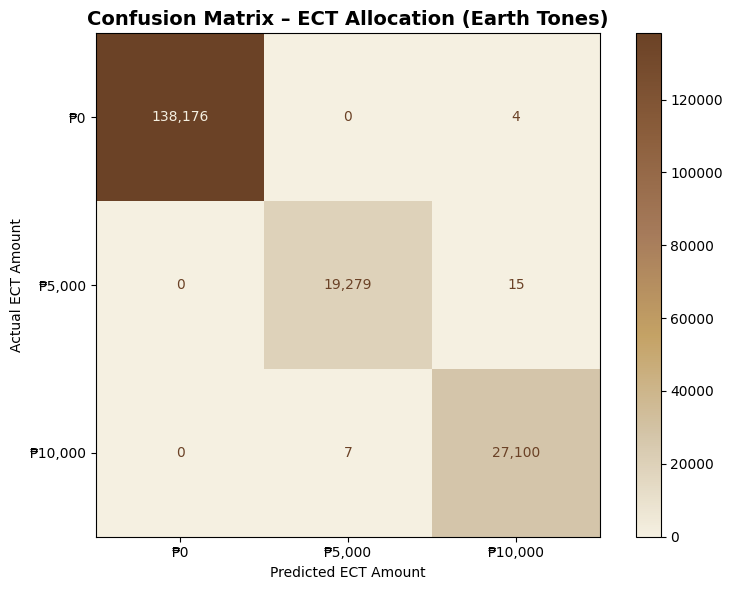

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Earth-tone colour map
earth_colors = ["#F5F0E1", "#D4C5A9", "#C4A265", "#A67B5B", "#8B5E3C", "#6B4226"]
earth_cmap = mcolors.LinearSegmentedColormap.from_list("earthtones", earth_colors)

# Build confusion matrix
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"₱{int(l):,}" for l in labels])
disp.plot(cmap=earth_cmap, ax=ax, values_format=",")
ax.set_title("Confusion Matrix – ECT Allocation (Earth Tones)", fontsize=14, fontweight="bold")
ax.set_xlabel("Predicted ECT Amount")
ax.set_ylabel("Actual ECT Amount")
plt.tight_layout()
plt.show()

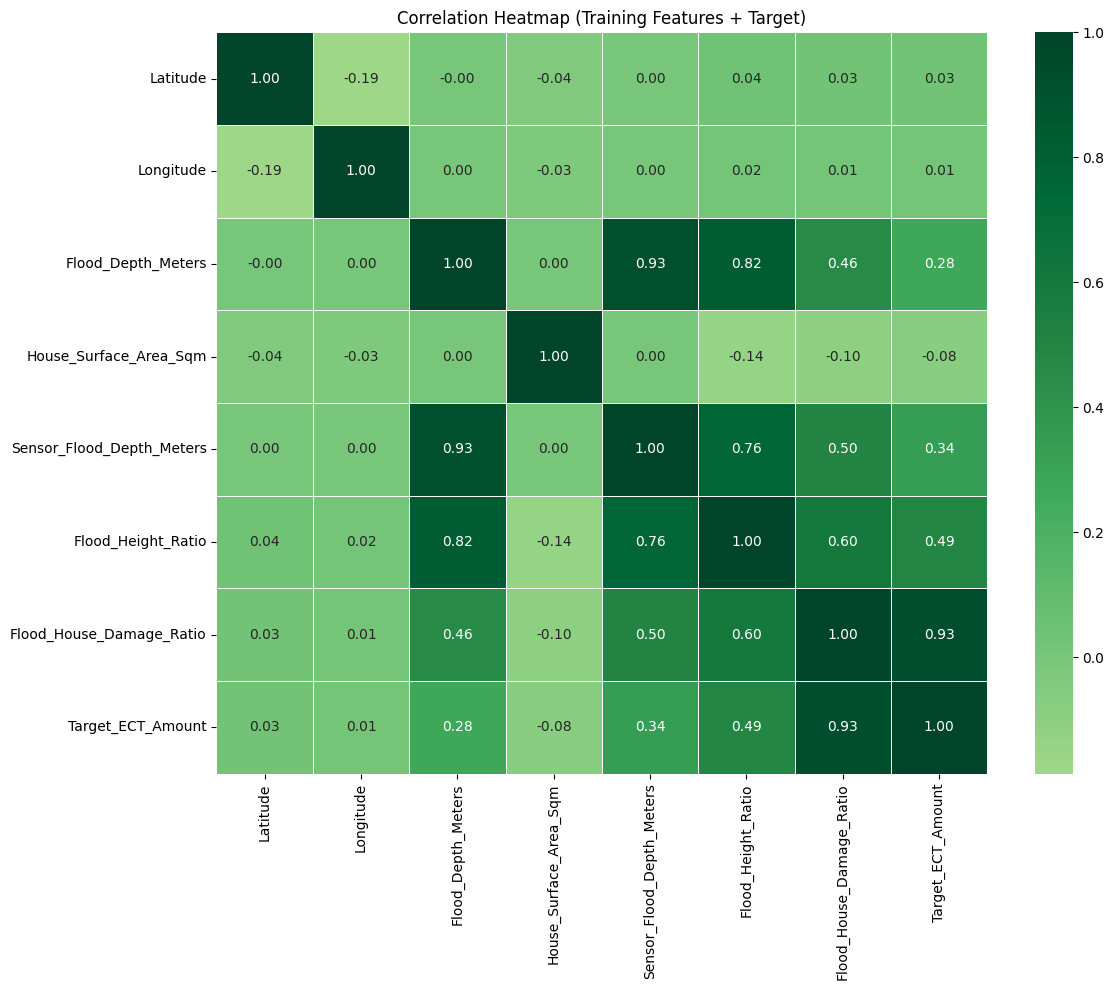

In [13]:
# Correlation heatmap of model results/features
numeric_cols = df_train.select_dtypes(include=['number']).columns
# Drop zero-variance columns (they produce NaN correlations)
numeric_cols = [c for c in numeric_cols if df_train[c].std() > 0]
corr_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlGn', center=0, linewidths=0.5)
plt.title("Correlation Heatmap (Training Features + Target)")
plt.tight_layout()
plt.show()

In [14]:
# Simulate a new batch of real-time data for recommendation
df_new = df_train.sample(n=10).reset_index(drop=True)
df_new['Household_ID'] = [f'HH-{i:05d}' for i in range(10)]
# Drop target before feeding to prediction
df_new = df_new.drop(['Target_ECT_Amount'], axis=1, errors='ignore')

# Calculate Flood_Height_Ratio for the new data (derived from surface area)
df_new['Flood_Height_Ratio'] = np.minimum(df_new['Flood_Depth_Meters'] / np.sqrt(df_new['House_Surface_Area_Sqm']), 1.0)

# Calculate Flood_House_Damage_Ratio for the new data
sensor_ratio = df_new['Sensor_Flood_Depth_Meters'] / df_new['Flood_Depth_Meters'].replace(0, np.nan)
df_new['Flood_House_Damage_Ratio'] = np.minimum(
    df_new['Flood_Height_Ratio'] * sensor_ratio.fillna(1.0),
    1.0,
)

# Make prediction
predictions = ect_model.predict(df_new.drop('Household_ID', axis=1, errors='ignore')).flatten().astype(int)
recommendations_df = df_new.copy()
recommendations_df['Recommended_ECT_Amount_PHP'] = predictions

In [15]:
# Output Summary
allocation_summary = recommendations_df.groupby('Recommended_ECT_Amount_PHP').size().reset_index(name='Households_Count')
total_budget_needed = allocation_summary.apply(lambda row: row['Recommended_ECT_Amount_PHP'] * row['Households_Count'], axis=1).sum()

print(f"\nTotal Budget Required for these {len(recommendations_df)} Households: PHP{total_budget_needed:,.0f}")
print("\nAllocation Summary:")
print(allocation_summary.to_markdown(index=False))

print("\n--- Sample Household Recommendations ---")
print(recommendations_df[['Household_ID', 'Recommended_ECT_Amount_PHP', 'Flood_Depth_Meters', 'House_Surface_Area_Sqm', 'Flood_Height_Ratio']].head(5).to_markdown(index=False))


Total Budget Required for these 10 Households: PHP5,000

Allocation Summary:
|   Recommended_ECT_Amount_PHP |   Households_Count |
|-----------------------------:|-------------------:|
|                            0 |                  9 |
|                         5000 |                  1 |

--- Sample Household Recommendations ---
| Household_ID   |   Recommended_ECT_Amount_PHP |   Flood_Depth_Meters |   House_Surface_Area_Sqm |   Flood_Height_Ratio |
|:---------------|-----------------------------:|---------------------:|-------------------------:|---------------------:|
| HH-00000       |                            0 |                 2.21 |                 253.564  |            0.138787  |
| HH-00001       |                            0 |                 2.23 |                 208.736  |            0.15435   |
| HH-00002       |                            0 |                 2.2  |                3250.7    |            0.0385864 |
| HH-00003       |                         5000 |

In [17]:
# Save model with timestamped versioned filename
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_filename = models_dir / f"{timestamp}ect_allocation_model.bin"
ect_model.save_model(str(model_filename))
print(f"Model saved as {model_filename}")

Model saved as /Users/gyalm/Desktop/ect_allocation_model/models/20260208-195751ect_allocation_model.bin


In [19]:
# Load the latest saved model from the models directory
models_dir = PROJECT_ROOT / "models"
model_files = sorted(models_dir.glob("*ect_allocation_model.bin"), reverse=True)

if not model_files:
    raise FileNotFoundError(f"No model files found in {models_dir}")

latest_model_path = model_files[0]

def load_model(file_path):
    loaded_model = CatBoostClassifier()
    loaded_model.load_model(str(file_path))
    print(f"Model loaded from {file_path}")
    return loaded_model

loaded_model = load_model(latest_model_path)

Model loaded from /Users/gyalm/Desktop/ect_allocation_model/models/20260208-195751ect_allocation_model.bin
